# Exercise Sheet 1



### Read the Dataset

- Use Pandas to read the 'covertype.csv' file
- The dataset contains information on different forest cover types
- Look at the columns. Which of them contain meaningful features?



### Seperate Features and Labels
- Define x as the vectors of meaningful features
- Define y as the labels (Cover_Type)



### Split the dataset into two disjoint datasets for training and testing
- Randomly split the dataset. Use 70% for training and 30% for testing.
- Define x_train and x_test as the feature vectors
- Define y_train and y_test as the labels
    - Hint: Have a look at the sklearn package

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

data = pd.read_csv("covertype.csv")
x = np.asarray(data.iloc[:, 1:-1])
# Adjust the labels between [0..n-1]
y = np.asarray([x-1 for x in data.iloc[:, -1]])

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.70,
                                            test_size = 0.30, random_state=42)
x

array([[2596,   51,    3, ...,    0,    0,    0],
       [2590,   56,    2, ...,    0,    0,    0],
       [2804,  139,    9, ...,    0,    0,    0],
       ...,
       [2492,  134,   25, ...,    0,    0,    0],
       [2487,  167,   28, ...,    0,    0,    0],
       [2475,  197,   34, ...,    0,    0,    0]])

### Train a simple deep neural network
- Use Pytorch to define a simple Multi-Layer Perceptron with at least 3 layers
    - The input layer should have as many neurons as there are features
        - How many features are there?
    - The last layer should have as many neurons as there are classes
        - How many classes are there?
- Pack your training and testing datasets in a class which inherits from torch.utils.data.Datset
    - features you input to your network should be of type torch.float
    - labels should be of type torch.long.
- Use a torch.utils.data.DataLoader to access your data in batches
- Train the MLP with your data from the train_loader using Cross-Entropy Loss and the Adam Optimizer
    - Make sure to save the training history for later assessment
- Evaluate the performance on your test_loader

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

from torch.utils.data import Dataset, DataLoader
from collections import Counter

# specify the dtype of input layer and output layer
dtype_in = torch.float
dtype_out = torch.long

# Define your MLP
class Model(nn.Module):
    def __init__(self, n_input, h1, h2, n_output):
      super(Model, self).__init__()
      self.layer1 = nn.Linear(n_input, h1)
      self.layer2 = nn.Linear(h1, h2)
      self.layer3 = nn.Linear(h2, n_output)

    def forward(self, input):
      h1_relu = F.relu(self.layer1(input))
      h2_relu = F.relu(self.layer2(h1_relu))
      y_pred = F.softmax(self.layer3(h2_relu))
      return y_pred

class ForestCoverDataset(Dataset):
    """Forest Cover dataset."""
    def __init__(self, features, labels):
      self.features = torch.tensor(features, dtype = dtype_in)
      self.labels = torch.tensor(labels, dtype = dtype_out)

    def __len__(self):
      return len(self.features)
    
    def __getitem__(self, idx):
      feature = self.features[idx]
      label = self.labels[idx]

      return feature, label

In [4]:
train_set = ForestCoverDataset(x_train, y_train)
test_set = ForestCoverDataset(x_test, y_test)

# set parameters
# input dimention
in_dim = len(x_train[0])

# output dimention
out_dim = len(np.unique(y_train))

# batch size
BS = 64

# define number of neurons in each layer
n_input, h1, h2, n_out = in_dim, 120, 100, out_dim

# learning rate
lr = 1e-1

print("Input Dimention : {}".format(in_dim))
print("Output Dimention : {}".format(out_dim))
print("Batch Size : {}".format(BS))
print("Learning Rate : {}".format(lr))

# Create your DataLoaders
train_loader = DataLoader(train_set, batch_size = BS, shuffle=True)
test_loader = DataLoader(test_set, batch_size = BS, shuffle=True)

Input Dimention : 54
Output Dimention : 7
Batch Size : 64
Learning Rate : 0.1


In [5]:
# instantiate the network, the optimizer and the Loss Criterion
model = Model(n_input, h1, h2, n_out)
print(model)

# loss function
criterion = torch.nn.CrossEntropyLoss()
print(criterion)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(optimizer)

Model(
  (layer1): Linear(in_features=54, out_features=120, bias=True)
  (layer2): Linear(in_features=120, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=7, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)


In [6]:
# Define your training Loop
def train_epoch(model, dataloader, criterion, optimizer):
    model = model.float()
    model.train()
    epoch_loss = 0
    correct = 0.
    samples = 0.
    for sample in dataloader:
        optimizer.zero_grad()
        data, label = sample
        prediction = model(data)
        loss = criterion(prediction, label)
        correct += sum(torch.argmax(prediction, dim=1) == label)
        samples += len(data)
        epoch_loss += loss.data
        loss.backward()
        optimizer.step()
    return epoch_loss, correct/samples


# Define your testing Loop
def test_epoch(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    correct = 0.
    samples = 0.
    for sample in dataloader:
        data, label = sample
        prediction = model(data)
        loss = criterion(prediction, label)
        correct += sum(torch.argmax(prediction, dim=1) == label)
        samples += len(data)
        epoch_loss += loss.data
    return epoch_loss, correct/samples


In [18]:
# Check if your training and testing loops are working
train_epoch(model, train_loader, criterion, optimizer)
test_epoch(model, test_loader, criterion)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(tensor(144.0328), tensor(0, dtype=torch.uint8))

### Debug
- If there is a RuntimeError raised in you loss function, either your network architecture or your data is faulty
    - Check your network architecture
    - Check your data
        - Are there any NaN or infinite features or labels?
    - Print the labels.
        - How many unique labels do you have?
        - Are they [0, ..., n-1]?
            - If not, align them

In [8]:
# Inspect your data






In [9]:
# Fix your data and recreate your DataLoaders





### Train your Network
- Reinitialize your MLP from above and train it for 100 epochs

In [10]:
import tqdm

# net = 
# optimizer = 
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

for i in tqdm.tnrange(100):
    loss, accuracy = train_epoch(model, train_loader, criterion, optimizer)
    train_loss.append(loss)
    train_accuracy.append(accuracy)
    loss, accuracy = test_epoch(model, test_loader, criterion)
    test_loss.append(loss)
    test_accuracy.append(accuracy)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


### Does it work?
- There should not be a RuntimeError raised now
- Does the network converge / Does the loss decrease?


### Visualize the training
- use matplotlib.pyplot to visualize the history
- plot both the training accuracy and the validation accuracy
- Does the training stagnate?

In [11]:
import matplotlib.pyplot as plt
plt.xlabel("accuracy")
plt.ylabel("loss")
plt.plot(train_accuracy, train_loss, label = "train set")
plt.plot(test_accuracy, test_loss, label = "test set")
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

### Inspect the data
- Compute the min, max, mean and standard deviation of each feature
- What data type do the columns have?
- Use Pandas to print the statistics in a table
- What could be problematic with the dataset?

In [12]:
pd.options.display.float_format = '{:.2f}'.format

stats = pd.DataFrame(columns=["Type", "Min", "Max", "Mean", "Std"])

# Compute the values for each column
typ = []
for i in range(in_dim):
  typ.append(x_train[:, i].dtype)
cmin, cmax, cmean, cstd = np.amin(x_train, axis = 0),\
                          np.amax(x_train, axis = 0),\
                          np.mean(x_train, axis = 0),\
                          np.std(x_train, axis = 0)

stats["Type"], stats["Min"], stats["Max"], stats["Mean"], stats["Std"]\
= typ, cmin, cmax, cmean, cstd

display(stats)

,Type,Min,Max,Mean,Std
0,int64,1888,3849,2752.25,416.07
1,int64,0,360,157.22,110.71
2,int64,0,52,16.43,8.42
3,int64,0,1343,227.55,209.00
4,int64,-134,547,51.26,60.98
5,int64,0,6836,1722.01,1334.71
6,int64,0,254,212.45,30.57
7,int64,99,254,219.01,22.71
8,int64,0,248,135.51,45.77
9,int64,0,6853,1516.27,1101.83


### Preprocess the Data
- Normalize or standardize your data, so all features are at the same scale.
    - This will help your network to use all available features and not be biased by some features with large values
    - Does it make sense to normalize all columns, or only some?
- Hint: Again, look if you find something useful in sklearn


- Never use test data to optimize your training! This includes the preprocessing
    - Find preprocessing parameters on your training data only!
    - Transform all your data with the computed parameters
    - You have to remember which of your samples are used for training and which are for testing


In [13]:
from sklearn import preprocessing
#Normalize the data
x_train = preprocessing.normalize(x_train, "l2")
x_test = preprocessing.normalize(x_test, "l2")

### Inspect data again
- Print the statistics of the preprocessed data using the code from above

In [14]:
stats = pd.DataFrame(columns=["Type", "Min", "Max", "Mean", "Std"])

# Compute the values for each column
typ = []
for i in range(in_dim):
  typ.append(x_train[:, i].dtype)
cmin, cmax, cmean, cstd = np.amin(x_train, axis = 0),\
                          np.amax(x_train, axis = 0),\
                          np.mean(x_train, axis = 0),\
                          np.std(x_train, axis = 0)

stats["Type"], stats["Min"], stats["Max"], stats["Mean"], stats["Std"]\
= typ, cmin, cmax, cmean, cstd

display(stats)

,Type,Min,Max,Mean,Std
0,float64,0.32,0.99,0.77,0.14
1,float64,0.00,0.17,0.05,0.04
2,float64,0.00,0.02,0.01,0.00
3,float64,0.00,0.28,0.06,0.05
4,float64,-0.04,0.14,0.01,0.02
5,float64,0.00,0.89,0.41,0.20
6,float64,0.00,0.13,0.06,0.02
7,float64,0.02,0.12,0.06,0.02
8,float64,0.00,0.11,0.04,0.02
9,float64,0.00,0.92,0.37,0.17


### Train the network again
- Recreate your DataLoaders with the normalized data
- Reinitialize or your MLP from above and train it again


In [15]:
# Recreate your DataLoaders with the normalized data
train_set = ForestCoverDataset(x_train, y_train)
test_set = ForestCoverDataset(x_test, y_test)

train_loader = DataLoader(train_set, batch_size = BS, shuffle = True)
test_loader = DataLoader(test_set, batch_size = BS, shuffle = True)

In [16]:
# learning rate
model = Model(n_input, h1, h2, n_out)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

for i in tqdm.tnrange(100):
    loss, accuracy = train_epoch(model, train_loader, criterion, optimizer)
    train_loss.append(loss)
    train_accuracy.append(accuracy)
    loss, accuracy = test_epoch(model, train_loader, criterion)
    test_loss.append(loss)
    test_accuracy.append(accuracy)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


### Visualize the training
- use matplotlib.pyplot to visualize the history
- plot both the training accuracy and the validation accuracy

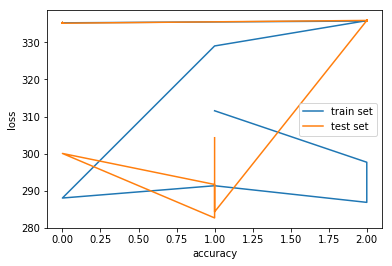

In [17]:
plt.xlabel("accuracy")
plt.ylabel("loss")
plt.plot(train_accuracy, train_loss, label = "train set")
plt.plot(test_accuracy, test_loss, label = "test set")
plt.legend()
plt.show()